In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import os
import warnings
import math
from abc import abstractmethod

warnings.filterwarnings("ignore")

In [2]:
# Defining the constants

OUTPUT_PATH = 'output/'
INPUT_PATH = 'dataset/'
BASE_FILE_NAME='btcusdt'
TIME_FRAMES=['1h']

SIGNALS = [-1,0,1]
PRICE_TYPES = ['open','close','high','low']

TIMEFRAME="1h"

PRICE_STUDY="close"
PRICE_TRADING="open"
RISK_FREE_RATE=4.04

In [3]:
# Defining the classes for Candle( PrVO) and Trade

class PrVO:
    def __init__(self,open:float,high:float,low:float,close:float,volume:int,timeStamp:datetime) -> None:
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.timeStamp = timeStamp
        self.returns = (close - open)/open
        self.candle_color = 'GREEN' if self.close > self.open else 'RED'

    def __repr__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
    def __str__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
class Trade:
    
    def __init__(self) -> None:
        self.timeStamp = None
        self.signal = None
        self.price_type = None
    
    # Arguments: PrVo, signal[1,-1], price_type
    def execute(self,PrVo:PrVO ,signal:int,price_type:str) -> object:
        
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"

        self.PrVo = PrVo
        self.signal = signal
        self.price_type = price_type
        return self
    
    def __str__(self) -> str:
        return f"{self.PrVo}\t{self.signal}\t {self.price_type}"
    

In [4]:
# Defining the Trading Terminal which generates indicators and executes trades

class TradingTerminal:

    # Constructor
    def __init__(self) -> None:
        self.PrVo=dict() # Various timeframe PrVo list
        self.cash_balance=1000 # Initial Cash Balance
        self.tradeHistory=[]  # List of trades
        self.transaction_penalty=0.001 # Transaction Penalty
        self.transaction_cost=0

        if '1d' in TIME_FRAMES: # creation of 1d timeframe
            self.create1DTimeFrame()

        for timeframe in TIME_FRAMES: # Reading the data
            self.readData(BASE_FILE_NAME+'_'+timeframe+'.xlsx')

    # Creating 1d timeframe from 30m timeframe
    def create1DTimeFrame(self):
        
        if os.path.isfile(INPUT_PATH+BASE_FILE_NAME+'_1d.xlsx'):
            return
        
        df=pd.read_excel(INPUT_PATH+BASE_FILE_NAME+'_30m.xlsx') # Reading 30m timeframe
        # performing transformations
        df['date']=df['datetime'].dt.date
        df['time']=df['datetime'].dt.time
        df=df.drop(columns=['datetime','time'])
        df=df.rename(columns={'date':'datetime'})
        df=df.groupby('datetime').agg({'low':lambda x: x.min(),'high':lambda x: x.max(),'open':lambda x: x.iloc[0],'close':lambda x: x.iloc[-1],'volume':lambda x: x.sum()})
        df.to_excel(INPUT_PATH+BASE_FILE_NAME+'_1d.xlsx')

    # Reading the data from the excel file and storing it in PrVo
    def readData(self,filepath:str):
        df=pd.read_excel(INPUT_PATH+filepath)
        
        data=[]
        for index,row in df.iterrows():
            data.append(PrVO(row['open'],row['high'],row['low'],row['close'],row['volume'],row['datetime'])) # Creating PrVo object and appending it to the list

        data_timeframe=filepath.split('/')[-1].split('.')[0].split('_')[1]
        self.PrVo[data_timeframe]=np.array(data)   # Storing the PrVo list in PrVo dictionary

    # Some basic checks are performed in many function described below        
    def takeTrade(self,PrVo:PrVO,signal:int,price_type:str):
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"

        trade=Trade().execute(PrVo,signal,price_type) # Executing the trade
        self.tradeHistory.append(trade)

    # creating logs from the trade history
    def outputTradeHistory(self):
        file=open(OUTPUT_PATH+'trades.csv','w')

        file.write(f"Index,datetime,signals,open,high,low,close,volume\n")
        
        for index,trade in enumerate(self.tradeHistory):
            file.write(f"{index},{trade.PrVo.timeStamp},{trade.signal},{trade.PrVo.open},{trade.PrVo.high},{trade.PrVo.low},{trade.PrVo.close},{trade.PrVo.volume}\n")

    # resetting the terminal
    def resetEverything(self):
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_cost=0

    # Statistics in a compounded manner
    def getstatsCompounded(self):

        equity_curve = np.array([])
        returns_curve = np.array([])
        coins_held=0

        # trades type and trades amount are used to calculate the statistics
        trades_type={"Winnings":0,"Losings":0,"Total":0}
        trades_amount={"Gain":0,"Loss":0}  
        Holding_time=[]
        prev_time=None

        Initial_cash_balance=self.cash_balance

        prev_trade_value=None    

        # Going through the trade history
        # The below functions works both for long and short trades
        # Assumptioon is that Only Signal 1 and -1 are used for trading and not 0
        for trade in self.tradeHistory:

            equity_value=self.cash_balance+abs(coins_held)*getattr(trade.PrVo,trade.price_type)
            equity_curve=np.append(equity_curve,equity_value)

            if coins_held == 0: # If no coins are held

                # Update the transaction cost,coins_held and cash_balance appropriately
                prev_trade_value=self.cash_balance
                self.transaction_cost+=self.transaction_penalty*self.cash_balance                
                if trade.signal==1:
                    coins_held=(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                elif trade.signal==-1:
                    coins_held=(-1)*(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                    
            
                self.cash_balance=0
                prev_time=trade.PrVo.timeStamp
                
            else: # If coins are held
                
                # Find value of those coins
                value_coins=abs(coins_held)*getattr(trade.PrVo,trade.price_type)
                
                # Update the transaction cost,coins_held and cash_balance appropriately
                self.transaction_cost+=self.transaction_penalty*value_coins
                trades_type['Total']+=1

                # Some checks regarding validity of the trade
                if trade.signal==1:
                    assert coins_held<0,"Coins Held should be negative"
                elif trade.signal==-1:
                    assert coins_held>0,"Coins Held should be positive"
                    
                self.cash_balance=(1-self.transaction_penalty)*value_coins
                coins_held=0

                # Update the trades type and trades amount
                trades_type['Winnings' if self.cash_balance>=prev_trade_value else 'Losings']+=1
                trades_amount['Gain'  if self.cash_balance>=prev_trade_value else 'Loss']+=self.cash_balance-prev_trade_value
                
                returns_curve=np.append(returns_curve,(self.cash_balance/prev_trade_value-1)*100)

                Holding_time.append(trade.PrVo.timeStamp-prev_time)
                prev_time=None

        # Printing essential Parameters
        print(f"Final Cash Balance : {self.cash_balance}")

        years=(self.tradeHistory[-1].PrVo.timeStamp-self.tradeHistory[0].PrVo.timeStamp).days/365
        annual_return=((self.cash_balance/Initial_cash_balance)**(1/years)-1)*100

        print(f"Annualized Return(%): {annual_return}") 

        if len(returns_curve)>1:
            print(f"Sharpe Ratio : {(annual_return-RISK_FREE_RATE)/np.std(returns_curve)}")
            print(f"Sortino Ratio : {(annual_return-RISK_FREE_RATE)/np.std(returns_curve[returns_curve<0])}")
        else:
            print(f"Sharpe and Sortino ratio are not defined")


        print("Transaction Cost : ",self.transaction_cost)
        print(f"Total Trades : {trades_type['Total']}")
        print(f"Winning Trades : {trades_type['Winnings']}")
        print(f"Losing Trades : {trades_type['Losings']}")
        print(f"Average Holding Time : {np.mean(Holding_time)}")
        print(f"Maximum Holding Time : {np.max(Holding_time)}")
        print(f"Maximum DrawDown : {self.calculateDrawdown(equity_curve)}")




        try:
            print(f"Winning Percentage : {100*trades_type['Winnings']/trades_type['Total']}")
        except:
            print(f"Winning Percentage: No trades were made")
        try:
            print(f"Average Profit per Wins: {trades_amount['Gain']/trades_type['Winnings']}")
        except:
            print(f"Average Profit per Wins : No Winning Trades were made")

        try:
            print(f"Average Lost per Loss: {trades_amount['Loss']/trades_type['Losings']}")
        except:
            print(f"Average Lost per Loss : No Losing Trades were made")
        
        try:
            print(f"Profit to Loss Ratio : {trades_amount['Gain']/abs(trades_amount['Loss'])}")
        except:
            print(f"Profit to Loss Ratio : No Losing Trades were made")
        
        print(f"Minimum Portfolio Value : {np.min(equity_curve)}")
        print(f"Maximum Portfolio Value : {np.max(equity_curve)}")

        # graphing the equity curve and returns curve
        self.graphCurve(equity_curve,"Equity")
        self.graphCurve(returns_curve,"Returns")

    # Statistics in a static manner
    def getstatsStatic(self):

        coins_held=0

        trades_type={"Winnings":0,"Losings":0,"Total":0}
        trades_amount={"Gain":0,"Loss":0}  

        TRADE_VALUE=1000      

        for trade in self.tradeHistory:

            if coins_held == 0:

                self.transaction_cost+=self.transaction_penalty*TRADE_VALUE

                if trade.signal==1:
                    coins_held=(TRADE_VALUE*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                elif trade.signal==-1:
                    coins_held=(-1)*(TRADE_VALUE*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                            
            else:

                value_coins=abs(coins_held)*getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.transaction_penalty*value_coins
                value_coins*=1-self.transaction_penalty
                trades_type['Total']+=1

                if trade.signal==1:
                    assert coins_held<0,"Coins Held should be negative"
                elif trade.signal==-1:
                    assert coins_held>0,"Coins Held should be positive"
                    
                coins_held=0
                trades_type['Winnings' if value_coins>TRADE_VALUE else 'Losings']+=1
                trades_amount['Gain'  if value_coins>TRADE_VALUE else 'Loss']+=value_coins-TRADE_VALUE



        print(f"Final Pnl : {trades_amount['Gain']+trades_amount['Loss']}")
        print("Transaction Cost : ",self.transaction_cost)
        print(f"Total Trades : {trades_type['Total']}")
        print(f"Winning Trades : {trades_type['Winnings']}")
        print(f"Losing Trades : {trades_type['Losings']}")

        try:
            print(f"Winning Percentage : {100*trades_type['Winnings']/trades_type['Total']}")
        except:
            print(f"Winning Percentage: No trades were made")
        try:
            print(f"Average Profit per Wins: {trades_amount['Gain']/trades_type['Winnings']}")
        except:
            print(f"Average Profit per Wins : No Winning Trades were made")

        try:
            print(f"Average Lost per Loss: {trades_amount['Loss']/trades_type['Losings']}")
        except:
            print(f"Average Lost per Loss : No Losing Trades were made")
        
        try:
            print(f"Profit to Loss Ratio : {trades_amount['Gain']/abs(trades_amount['Loss'])}")
        except:
            print(f"Profit to Loss Ratio : No Losing Trades were made")

    # Calculating the drawdown
    def calculateDrawdown(self,equity_curve:[float]):
        max_drawdown = 0
        peak = equity_curve[0]
        for equity in equity_curve:
            peak=max(peak,equity)
            max_drawdown=max(max_drawdown,1-equity/peak)
        return max_drawdown

    # Graphing the equity curve and returns curve
    def graphCurve(self,equity_curve:[float],label:str):

        if len(equity_curve)<2:
            print(f"Not enough data to plot {label} curve")
            return
        sns.set()
        plt.figure(figsize=(8, 8))
        plt.plot(equity_curve)
        plt.xlabel("Transactions" if label=="Equity" else "Trades")
        plt.ylabel(f'{label} Curve')
        plt.show()

    # Graphing the Bitcoin index      
    def graphIndex(self,timeframe:str,price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sns.set()
        plt.figure(figsize=(8, 8))
        plt.plot(prices)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()

    # INDICATORS

    # The below two function calculates the simple moving average and exponential moving average
        
    def getSimpleMovingAverage(self, lag:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"
        
        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = np.convolve(prices, np.ones(lag) / lag, mode='valid')
        sma = np.concatenate([np.full(lag - 1, np.nan), sma])
        return sma

    def getExponentialMovingAverage(self, span:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        ema = pd.Series(prices).ewm(span=span, adjust=False).mean().values
        return ema
    
    # The below function calculates the bollinger bands
    def getBollingerBands(self, lag:int, std_dev_factor:float, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = self.getExponentialMovingAverage(lag, timeframe, price_type) # Calculating the EMA
        
        rolling_std = pd.Series(prices).rolling(window=lag).std().values # Calculating the rolling standard deviation

        upper_band = sma + std_dev_factor * rolling_std # Calculating the upper band
        lower_band = sma - std_dev_factor * rolling_std # Calculating the lower band

        return (upper_band, sma, lower_band)

    # Calculating the RSI
    def calculateRSI(self, period:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPES, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])

        price_changes = np.diff(prices)

        gains = np.where(price_changes > 0, price_changes, 0) # getting positive returns
        losses = np.where(price_changes < 0, -price_changes, 0) # getting negative returns
        
        # Calculating the average gain and average loss
        avg_gain = np.mean(gains[:period])
        avg_loss = np.mean(losses[:period])
        rsi_values = np.zeros_like(prices)

        # Calculating the RSI using standard formula
        for i in range(period, len(prices)):
            gain = gains[i - 1] if price_changes[i - 1] > 0 else 0
            loss = losses[i - 1] if price_changes[i - 1] < 0 else 0

            avg_gain = (avg_gain * (period - 1) + gain) / period
            avg_loss = (avg_loss * (period - 1) + loss) / period

            rs = avg_gain / avg_loss if avg_loss != 0 else np.inf
            rsi_values[i] = 100 - (100 / (1 + rs))

        return rsi_values


In [5]:
# Defining the Abstract Strategy Class
class Strategy:
    def __init__(self,TradingTerminal:TradingTerminal) -> None:
        self.terminal=TradingTerminal

    @abstractmethod
    def run(self, *args):
        pass

In [6]:
# Defining the Buy and Hold Strategy
class Benchmark(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,timeframe:str):
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()

        PrVo=self.terminal.PrVo[timeframe]
        self.terminal.takeTrade(PrVo[0], 1, "open") # Buy at the open of the first candle
        self.terminal.takeTrade(PrVo[-1], -1, "close")  # Sell at the close of the last candle  

In [7]:
class Strategy_Technical_Analysis(Strategy):
    def __init__(self, TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self, lag1: int, lag2: int, timeframe: str, std_dev_factor: float):
        
        # checking some preconditions
        assert lag1 > lag2, f"Invalid Lag {lag1} {lag2}" 
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        # setting terminal up and getting indicators value
        self.terminal.resetEverything()
        PrVo = self.terminal.PrVo[timeframe]
        sma1 = self.terminal.getSimpleMovingAverage(lag1, timeframe, PRICE_STUDY)
        sma2 = self.terminal.getSimpleMovingAverage(lag2, timeframe, PRICE_STUDY)
        rsi = self.terminal.calculateRSI(lag2, timeframe, PRICE_STUDY)
        upper_band, _, lower_band = self.terminal.getBollingerBands(lag1, std_dev_factor, timeframe, PRICE_STUDY)
        
        # setting up trading variables and various factors
        moving_average_crossover_buying_factor = 1.0075
        moving_average_crossover_selling_factor = 1.015
        bollinger_band_factor = 1.0125

        stop_loss_factor=0.975

        stop_loss_restrict_trade=0
        previous_purchase_price=None


        has_purchased = False

        # This is a LONG only strategy and hence there is no shorting
        # iterating over each day, this is similiar to us fetching data timeframe wise
        for idx, (sma1_val, sma2_val, rsi_val, upper, lower) in enumerate(zip(sma1, sma2, rsi, upper_band, lower_band)):

            # have coins
            if not has_purchased: 
                if ( (sma2_val >= moving_average_crossover_buying_factor * sma1_val and rsi_val >=70)
                    or getattr(PrVo[idx],PRICE_STUDY) >= bollinger_band_factor*upper): # Conditions of buy are being satisfied

                    if stop_loss_restrict_trade>0:  # restriction due to stoploss in previous trade
                        stop_loss_restrict_trade-=1
                        continue
                    
                    # buy the coin
                    self.terminal.takeTrade(PrVo[idx+1], 1,PRICE_TRADING) 
                    has_purchased = True
                    previous_purchase_price=getattr(PrVo[idx+1],PRICE_TRADING)
            # Don't have coins
            elif has_purchased:
                if ( (sma2_val <= moving_average_crossover_selling_factor * sma1_val and rsi_val <= 45)
                    or getattr(PrVo[idx],PRICE_STUDY) <= bollinger_band_factor*lower 
                    or getattr(PrVo[idx],PRICE_TRADING) <= stop_loss_factor*previous_purchase_price): # Condition for selling

                    if getattr(PrVo[idx],PRICE_TRADING) <= stop_loss_factor*previous_purchase_price: # selling due to hitting stoploss
                        stop_loss_restrict_trade=5  # restricting trade for next 5 signals

                    # sell the coin
                    self.terminal.takeTrade(PrVo[idx+1], -1,PRICE_TRADING)
                    has_purchased = False

        # square off the trade if still have coins
        if has_purchased:
            self.terminal.takeTrade(PrVo[-1], -1, PRICE_TRADING)

In [8]:
tt=TradingTerminal() # Creating the Trading Terminal

Final Cash Balance : 3105.1895225527046
Annualized Return(%): 32.4399874906556
Sharpe and Sortino ratio are not defined
Transaction Cost :  4.108297820373078
Total Trades : 1
Winning Trades : 1
Losing Trades : 0
Average Holding Time : 1472 days 00:00:00
Maximum Holding Time : 1472 days 00:00:00
Maximum DrawDown : 0
Winning Percentage : 100.0
Average Profit per Wins: 2105.1895225527046
Average Lost per Loss : No Losing Trades were made
Profit to Loss Ratio : No Losing Trades were made
Minimum Portfolio Value : 1000.0
Maximum Portfolio Value : 3108.2978203730777


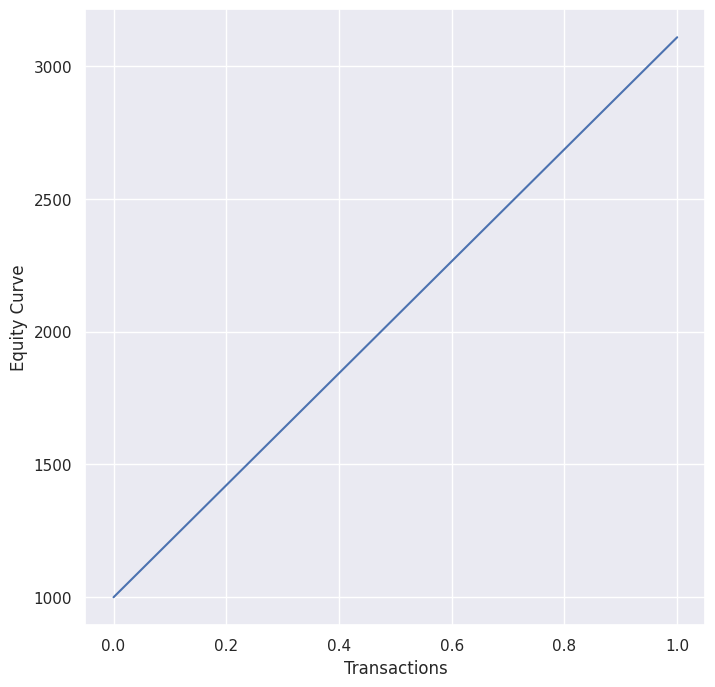

Not enough data to plot Returns curve


In [9]:
s0=Benchmark(tt)
s0.run(TIMEFRAME)
tt.getstatsCompounded()

Final Cash Balance : 17207.05372645638
Annualized Return(%): 106.73195274552079
Sharpe Ratio : 7.559634821663217
Sortino Ratio : 86.63072911556729
Transaction Cost :  928.9962360850343
Total Trades : 80
Winning Trades : 31
Losing Trades : 49
Average Holding Time : 6 days 10:39:00
Maximum Holding Time : 28 days 18:00:00
Maximum DrawDown : 0.2248530743963315
Winning Percentage : 38.75
Average Profit per Wins: 825.0829996281493
Average Lost per Loss: -191.23508697992344
Profit to Loss Ratio : 2.729579041809591
Minimum Portfolio Value : 958.4121017253901
Maximum Portfolio Value : 18124.6010229048


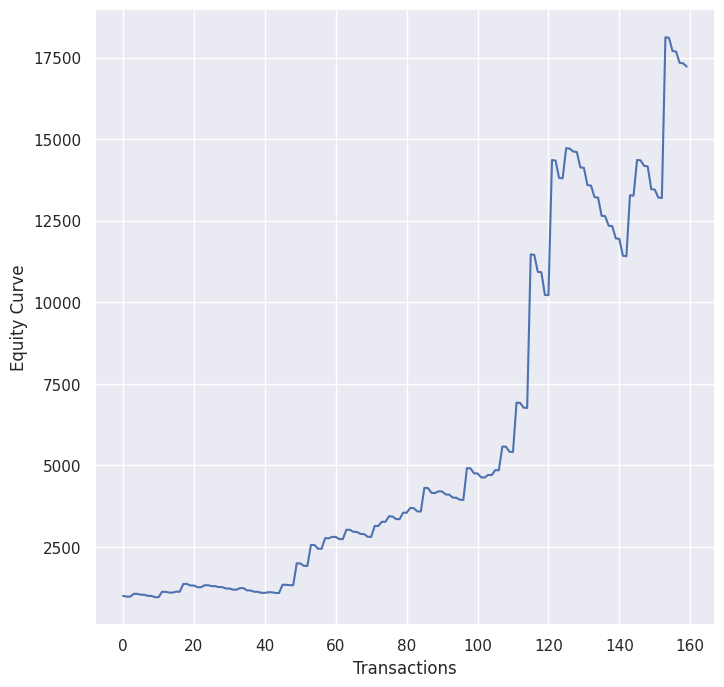

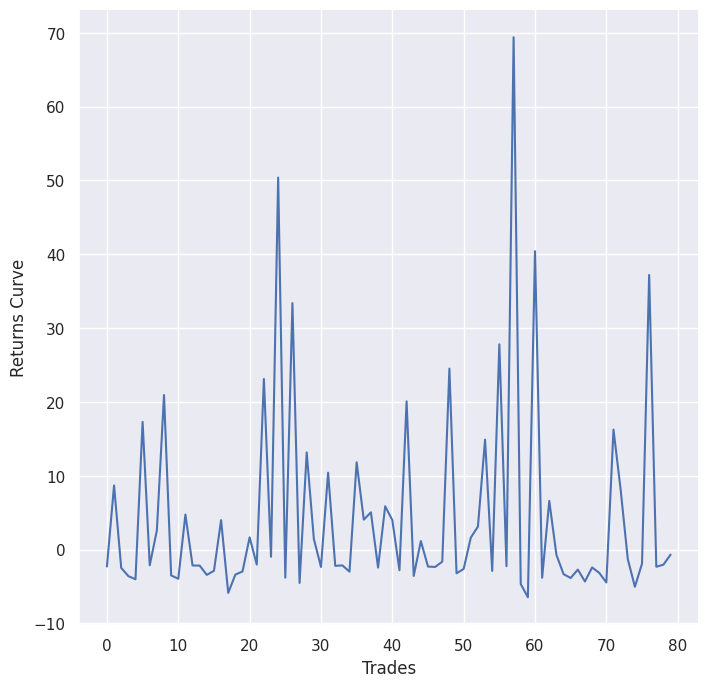

In [10]:
s1 = Strategy_Technical_Analysis(tt) # Creating the Strategy
s1.run(150, 50,TIMEFRAME, 1) # Running the Strategy
tt.outputTradeHistory()
tt.getstatsCompounded()